In [25]:
from matplotlib import image
import matplotlib.pyplot as plt
import numpy as np
import torch

%load_ext autoreload
%autoreload 2

from IPython.display import clear_output 
clear_output(wait = True)
import sys 
sys.path.append('..')
from models import LocationScaleFlow, SoftmaxWeight, SoftmaxWeightOver,DIFDensityEstimator, MixedModelDensityEstimator, RealNVPDensityEstimatorLayer, MultivariateNormalReference, EMDensityEstimator
from utils.color_visual import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


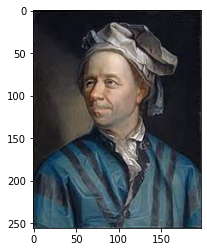

In [26]:
rgb = image.imread("euler.jpg")
plt.imshow(rgb)

<ipython-input-49-fa747eb203be>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.imshow(torch.tensor(grey))


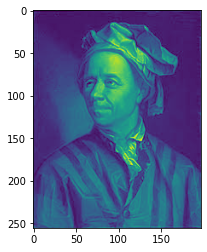

In [49]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
grey = torch.tensor(rgb2gray(rgb))
plt.imshow(torch.tensor(grey))

In [46]:
vector_density = torch.tensor(grey).flatten()
vector_density = vector_density/torch.sum(vector_density)
lignes, colonnes = grey.shape
num_samples = 100000
cat = torch.distributions.Categorical(probs = vector_density)
categorical_samples = cat.sample([num_samples])
target_samples = torch.cat([(categorical_samples//colonnes).unsqueeze(-1), (categorical_samples%colonnes).unsqueeze(-1)], dim = -1) + 0.01*torch.randn([num_samples,2])
plt.scatter(target_samples[:,0], target_samples[:, 1], alpha = .1, marker = '.')

<ipython-input-46-916063deb8b8>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vector_density = torch.tensor(grey).flatten()


ValueError: Expected parameter probs (Tensor of shape (50432,)) of distribution Categorical(probs: torch.Size([50432])) to satisfy the constraint Simplex(), but found invalid values:
tensor([1.8048e-05, 1.6424e-05, 1.7762e-05,  ..., 2.0918e-05, 2.0996e-05,
        2.0594e-05], dtype=torch.float64)

In [50]:
num_samples = target_samples.shape[0]
epochs = 200
K = 20
EM = EMDensityEstimator(target_samples,K)
loss_values = EM.train(epochs,visual=True)

  8%|█████████                                                                                                                | 15/200 [00:04<00:58,  3.15it/s, loss = 10.889349937438965]


KeyboardInterrupt: 

In [ ]:
delta = 300
grid = torch.cartesian_prod(torch.linspace(-lignes/2, 1.5*lignes,2*lignes),torch.linspace(-colonnes/2, 1.5*colonnes, 2*colonnes))
density = torch.exp(EM.log_density(grid)).reshape(2*lignes,2*colonnes).T.cpu().detach()
fig = plt.figure(figsize =(10,10))
plt.imshow(torch.flip(torch.flip(density.T,[0,1]),[0,1]))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [2:12:59<00:00, 79.79s/it, loss = 10.499661445617676]


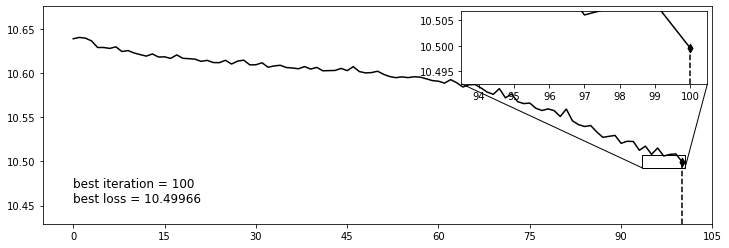

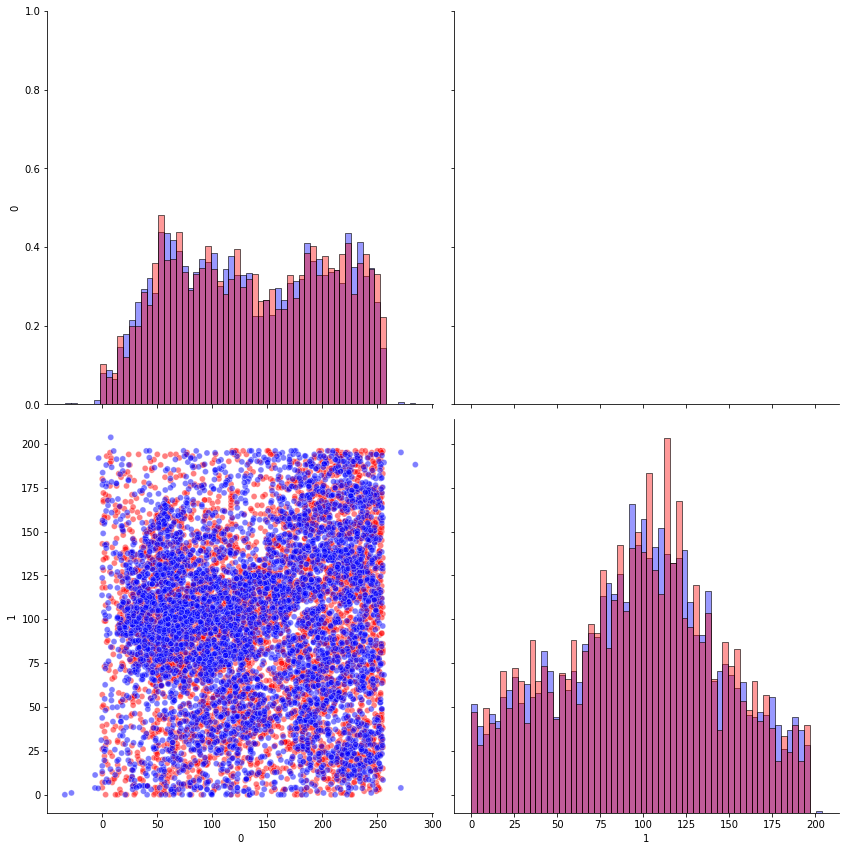

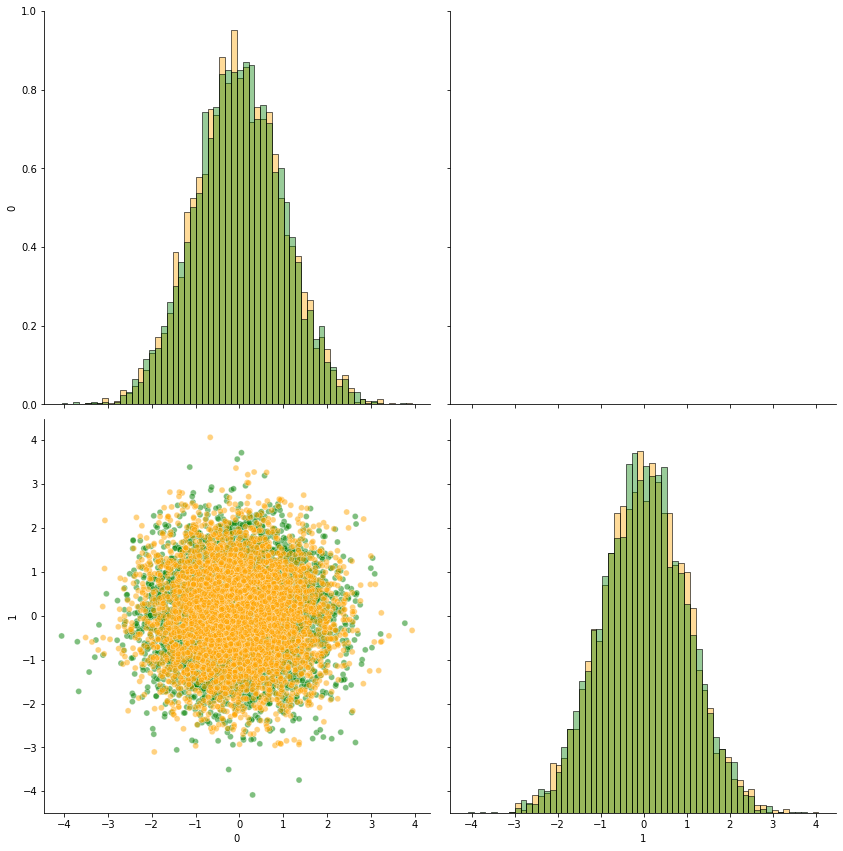

In [13]:
from torch import nn
num_samples = target_samples.shape[0]
epochs = 100
batch_size = 1000
initial_T = EM.T
initial_w = SoftmaxWeightOver(K, 2, [64,64,64], mode = 'NN')
initial_w.f[-1].weight = nn.Parameter(torch.zeros(K, 64))
initial_w.f[-1].bias = nn.Parameter(EM.log_pi)
dif = DIFDensityEstimator(target_samples,K, initial_T= initial_T, initial_w = initial_w)
loss_values = dif.train(epochs,batch_size,visual=True)
dif.model_visual()

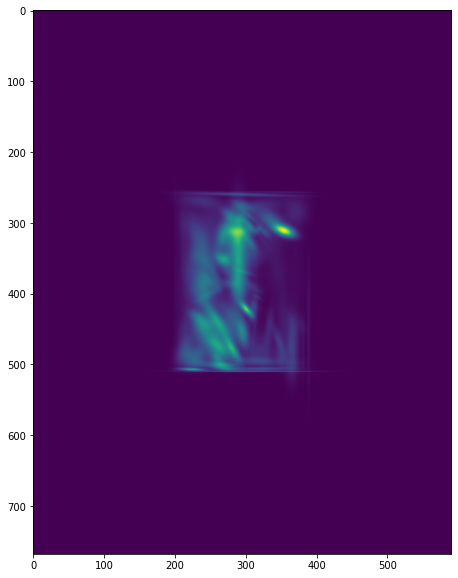

In [24]:
fig = plt.figure(figsize =(10,10))
delta = 300
grid = torch.cartesian_prod(torch.linspace(-lignes, 2*lignes,3*lignes),torch.linspace(-colonnes, 2*colonnes, 3*colonnes))
density = torch.exp(EM.log_density(grid)).reshape(3*lignes,3*colonnes).T.cpu().detach()
plt.imshow(torch.flip(torch.flip(density.T,[0,1]),[0,1]))
#print(dif.loss(target_samples))

In [19]:
loss_values = dif.train(2*epochs,10000,visual=True)

 21%|█████████████████████████▏                                                                                              | 42/200 [59:58<3:45:37, 85.68s/it, loss = 9.761338233947754]


KeyboardInterrupt: 